# Plot the outcome of potential DCO systems

I define "potential DCO" as systems that form a DCO at any metallicity in my discrete grid of metallicities

In [1]:
import numpy as np
from astropy.table import Table
import os 
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import colorsys

from tkinter import font
from matplotlib.gridspec import GridSpec
from pyrsistent import b


home_dir = os.path.expanduser("~") 
bse_grid_loc = home_dir + "/Winds2/code/GridSubmitCOMPAS/masterfolder/"
datar_root = home_dir + "/ceph/CompasOutput/v02.46.01/"#v02.35.02/"
sim_name = 'DiscreteMetallicities'#'  'DiscreteMetallicities_noBHkick' # 

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


# Turn off natural name warning for panda tables (this is due to '@' and '>' in the COMPAS column names)
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

######################################
# Helper function to make color darker
def darken_color(color, factor=0.8):
    r, g, b = (int(color[i:i+2], 16)/255 for i in (1, 3, 5))
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return '#%02x%02x%02x' % tuple(int(x*255) for x in colorsys.hls_to_rgb(h, l*factor, s))



# Data manipulation

Happens in [ DataManipulation notebook](./DataManipulation.ipynb)

In [2]:
####################################
# Take the base potential DCO progenitor table
prog_table_name = 'potential_DCO_progenitors_Allinfo.h5'

if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
    potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/' + prog_table_name, key='All_DCO')
    print('Table exists, reading in... ',  potential_DCO_progenitors.info())
else:
    print('error, table doesnt exist, you should make it using "DataManipulation.ipynb" first')

potential_DCO_progenitors.reset_index(drop=True, inplace=True)
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119952 entries, 0 to 119951
Data columns (total 95 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SEED                                  119952 non-null  uint64 
 1   Metallicity@ZAMS(1)                   119952 non-null  float64
 2   Stellar_Type(1)                       119952 non-null  int32  
 3   Stellar_Type(2)                       119952 non-null  int32  
 4   CE_Event_Counter                      119952 non-null  uint32 
 5   Mass@ZAMS(1)                          119952 non-null  float64
 6   Mass@ZAMS(2)                          119952 non-null  float64
 7   SemiMajorAxis@ZAMS                    119952 non-null  float64
 8   Merger                                119952 non-null  uint8  
 9   Merger_At_Birth                       119952 non-null  uint8  
 10  Unbound                               119952 non-null  uint8  
 11  

## Split your potential DCO table between potential BBH, BHNS and NSNS

In [3]:
with h5.File(datar_root+f'{sim_name}/COMPAS_Output_combinedZ.h5', 'r') as All_data:
    DCO = All_data['BSE_Double_Compact_Objects']
    st1 = DCO['Stellar_Type(1)'][()]
    st2 = DCO['Stellar_Type(2)'][()]
    dco_merger = DCO['Merges_Hubble_Time'][()]  
    DCO_seed = DCO['SEED'][()]
    # Now I want to add a bool that tells me if this system is ever a BBH, BHNS or BNS progenitor
    BBH_bool = np.logical_and(st1 == 14,st2 == 14)
    BHNS_bool = np.logical_or(np.logical_and(st1 == 13,st2 == 14),
                            np.logical_and(st1 == 14,st2 == 13) )
    NSNS_bool = np.logical_and(st1 == 13,st2 == 13)
    merger_bool = dco_merger == 1

    # Split our potential DCO progenitors into BBH, BHNS and NSNS progenitors
    potential_BBH_progenitors  = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BBH_bool*merger_bool]) )]
    potential_BHNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BHNS_bool*merger_bool]) )]
    potential_NSNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[NSNS_bool*merger_bool]) )]



# Now plot the endpoint of all potential DCO systems at different metallicities



In [4]:

def get_endpoint_numbers(table = potential_DCO_progenitors):

    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

    N_tot_DCO_prog  = grouped_byZ.size()

    N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
    N_mergers       = grouped_byZ['Merger'].apply(lambda x: (x==1).sum())

    # Make sure all the things below are not unbound or mergers
    not_unbound_nor_merger = np.logical_and(table['Unbound'] == 0, table['Merger'] == 0)
    DCO_merger      = (table['Merges_Hubble_Time'] == 1)

    N_BBH           = grouped_byZ.apply(lambda x: (not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() ) 
    N_mergingBBH    = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() ) 

    N_BHNS          = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
                                                        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))).sum())
    N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
                                                        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))).sum())

    N_NSNS          = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )
    N_mergingNSNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )

    N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())
    N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() ) 


    # IDK whats going on here?
    not_unbound         = table['Unbound'] == 0
    not_merger          = table['Merger'] == 0
    not_BBH             = ~np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 14)
    not_NSBH            = ~np.logical_or(np.logical_and(table['Stellar_Type(1)'] == 13, table['Stellar_Type(2)'] == 14),
                                np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 13))
    not_NSNS            = ~np.logical_and(table['Stellar_Type(1)'] == 13, table['Stellar_Type(2)'] == 13)
    not_massless_rem    = ~(np.logical_or(table['Stellar_Type(1)'] == 15, table['Stellar_Type(2)'] == 15))
    not_WD              = ~(np.logical_or(table['Stellar_Type(1)'].isin([10, 11, 12]), table['Stellar_Type(2)'].isin([10, 11, 12])))

    other_bool = not_unbound* not_merger * not_BBH * not_NSBH * not_NSNS * not_massless_rem * not_WD
    # Check if there are thing that are both listed as BBH and unbound
    BBH_and_unbound = (np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 14) * (table['Unbound'] == 1)  )
    print('BBH and unbound', BBH_and_unbound.sum())

    return  N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool


# N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool = get_endpoint_numbers(table = potential_DCO_progenitors)


In [5]:
# Function below is super slow.. working on multiprocessing
# from multiprocessing import Pool

# dfs = [potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

# # Create a pool of workers
# with Pool() as pool:
#     # Use the pool's map method to apply the function to all DataFrames
#     results = pool.map(get_endpoint_numbers, dfs)


# N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool = get_endpoint_numbers(table = df)


In [6]:
# Preload the data to speed up the plotting 
# List of panda tables of pot DCO progenitors
titles = ["All", "BBH", "BHNS", "NSNS"]
# List of tables of pot DCO progenitors
dfs = [potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

# Initialize an empty dictionary to store the results
results = {}

# Loop over the dataframes and titles
for df, title in zip(dfs, titles):
    # Get the results from get_endpoint_numbers
    results[title] = get_endpoint_numbers(table = df)



BBH and unbound 27295
BBH and unbound 6264
BBH and unbound 676
BBH and unbound 40


metallicities [0.0001     0.00017321 0.0003     0.00054772 0.001      0.002
 0.004      0.00632456 0.01       0.01414214 0.02       0.03      ]


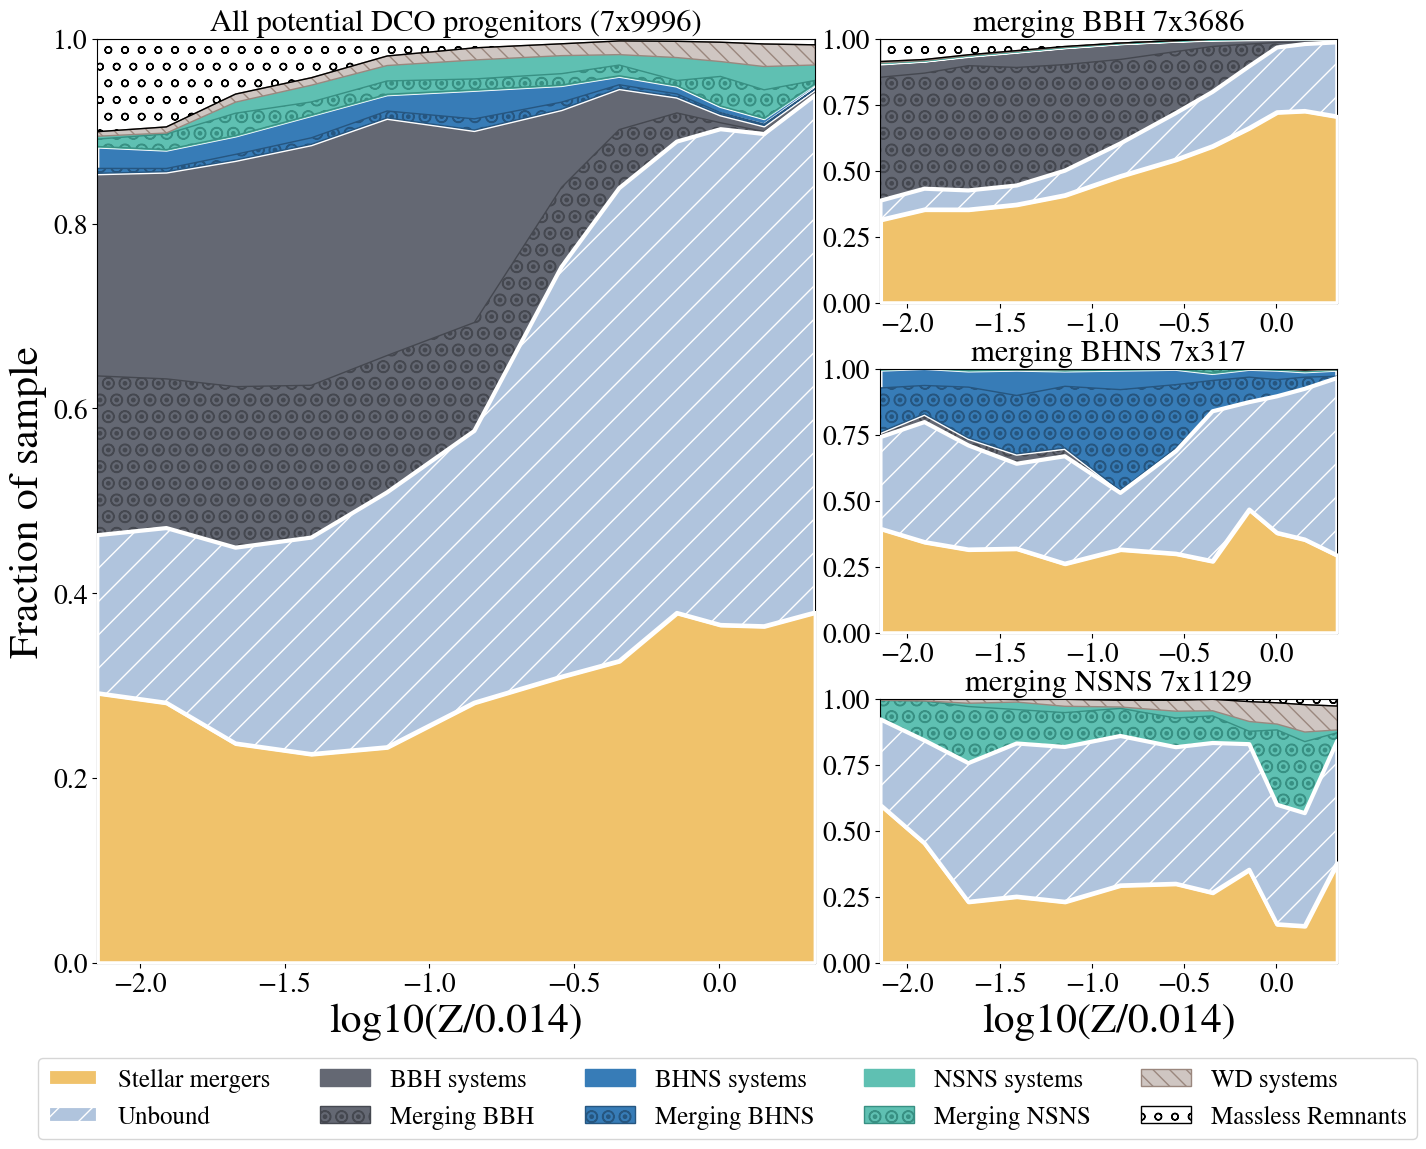

In [7]:
metallicities = np.unique(potential_DCO_progenitors['Metallicity@ZAMS(1)'])
print('metallicities', metallicities)   
Z_Zsun = np.log10(np.array(metallicities)/0.014)

###########################################
# Create a figure
fig = plt.figure(figsize=(16, 12))

# Create a GridSpec with 3 rows and 2 columns
gs = GridSpec(3, 10, figure=fig)#, width_ratios=[60, 40])
ax1 = fig.add_subplot(gs[:, 0:6])    # Create a big subplot on the left (for all DCOs)
axes = [ax1, fig.add_subplot(gs[0, 6:10]), fig.add_subplot(gs[1, 6:10]), fig.add_subplot(gs[2, 6:10])]  #  3 small subplots on the right


# Colors
color_dict = {'BBH': '#646873', 
              'BHNS': '#377CB7',#'#4D7DAF', #'#e8485a', 
              'NSNS': '#5FC0B2',#'#8ECCF2', #'#8CBFDA',#'#778FD2',#91c74c',
              'WDWD': '#cfc6c2',
              'masslessRemnants': '#000000',
              'StellarMergers': '#F0C26B', #'#DDBD76'
              'UnboundSystems': '#b0c4dd'} #'#F4C6B9'


DCO_flavors = ["All", "BBH", "BHNS", "NSNS"]
# Loop over the axes and DCO flavors
for ax, flavor in zip(axes, DCO_flavors):
    N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool = results[flavor] # get_endpoint_numbers(table = df)

    # Normalize or abs numbers?
    norm = N_tot_DCO_prog

    bottom = np.zeros(len(Z_Zsun))

    # stellar mergers
    ax.fill_between(Z_Zsun, bottom/norm, N_mergers/norm, color=color_dict['StellarMergers'], 
                    edgecolor = 'white', lw = 3, label='Stellar mergers', alpha = 1, zorder = 10)
    bottom += N_mergers

    # Unbound systemd
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_unbound)/norm, color=color_dict['UnboundSystems'],
                     edgecolor = 'white', lw = 3,  hatch='/', label='Unbound', alpha = 1, zorder = 10)
    bottom += N_unbound

    # BBH systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BBH)/norm, color=color_dict['BBH'], label='BBH systems', alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingBBH)/norm, color=color_dict['BBH'], 
                    edgecolor = darken_color(color_dict['BBH'], factor=0.7), hatch='O.', label='Merging BBH', alpha = 1)
    bottom += N_BBH

    # BHNS systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BHNS)/norm, color=color_dict['BHNS'], label='BHNS systems', alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BHNS)/norm, color="none", 
                    edgecolor = 'white', lw = 3, label=None, alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingBHNS)/norm, color=color_dict['BHNS'], 
                    edgecolor = darken_color(color_dict['BHNS'], factor=0.7), hatch='O.', label='Merging BHNS', alpha = 1)
    bottom += N_BHNS

    # NSNS systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_NSNS)/norm, color=color_dict['NSNS'], label='NSNS systems', alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingNSNS)/norm, color=color_dict['NSNS'], 
                    edgecolor = darken_color(color_dict['NSNS'], factor=0.7), hatch='O.', label='Merging NSNS', alpha = 1)
    bottom += N_NSNS

    # WD systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_WD)/norm, color=color_dict['WDWD'],
                     edgecolor=darken_color(color_dict['WDWD'], factor=0.7), hatch = '\\\\', label='WD systems', alpha = 1)   
    bottom += N_WD

    # Massless remnants
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_massless_rem)/norm, color='none',edgecolor=color_dict['masslessRemnants'], hatch = 'o', label='Massless Remnants', alpha = 1)
    bottom += N_massless_rem

    # Other
    # print(N_other)
    # ax.fill_between(Z_Zsun, bottom, (bottom + N_other)/norm, color='r', label='Other', alpha = 1)

    if flavor == 'All':
        ax.set_title(f'All potential DCO progenitors (7x{N_tot_DCO_prog[0.0001]})', fontsize = 22)
    else:
        ax.set_title(f'merging {flavor} 7x{N_tot_DCO_prog[0.0001]}', fontsize = 22)
        
    ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
    ax.set_ylim(0,1)

#########################
# plotvalues
fig.subplots_adjust(hspace=0.25, wspace=1)

axes[0].set_xlabel('log10(Z/0.014)', fontsize = 30)
axes[3].set_xlabel('log10(Z/0.014)', fontsize = 30)
axes[0].set_ylabel("Fraction of sample", fontsize =30)

axes[0].legend(bbox_to_anchor=(-0.1, -0.09), loc='upper left', fontsize = 18, ncols = 5)
# axes[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize = 20)

plt.savefig(home_dir + f'/Winds2/plots_v46/End_Of_Evol_per_Z_{sim_name}.pdf', bbox_inches='tight')
plt.show()


In [9]:
stiopo

NameError: name 'stiopo' is not defined

metallicities [0.0001     0.00017321 0.0003     0.00054772 0.001      0.002
 0.004      0.00632456 0.01       0.01414214 0.02       0.03      ]


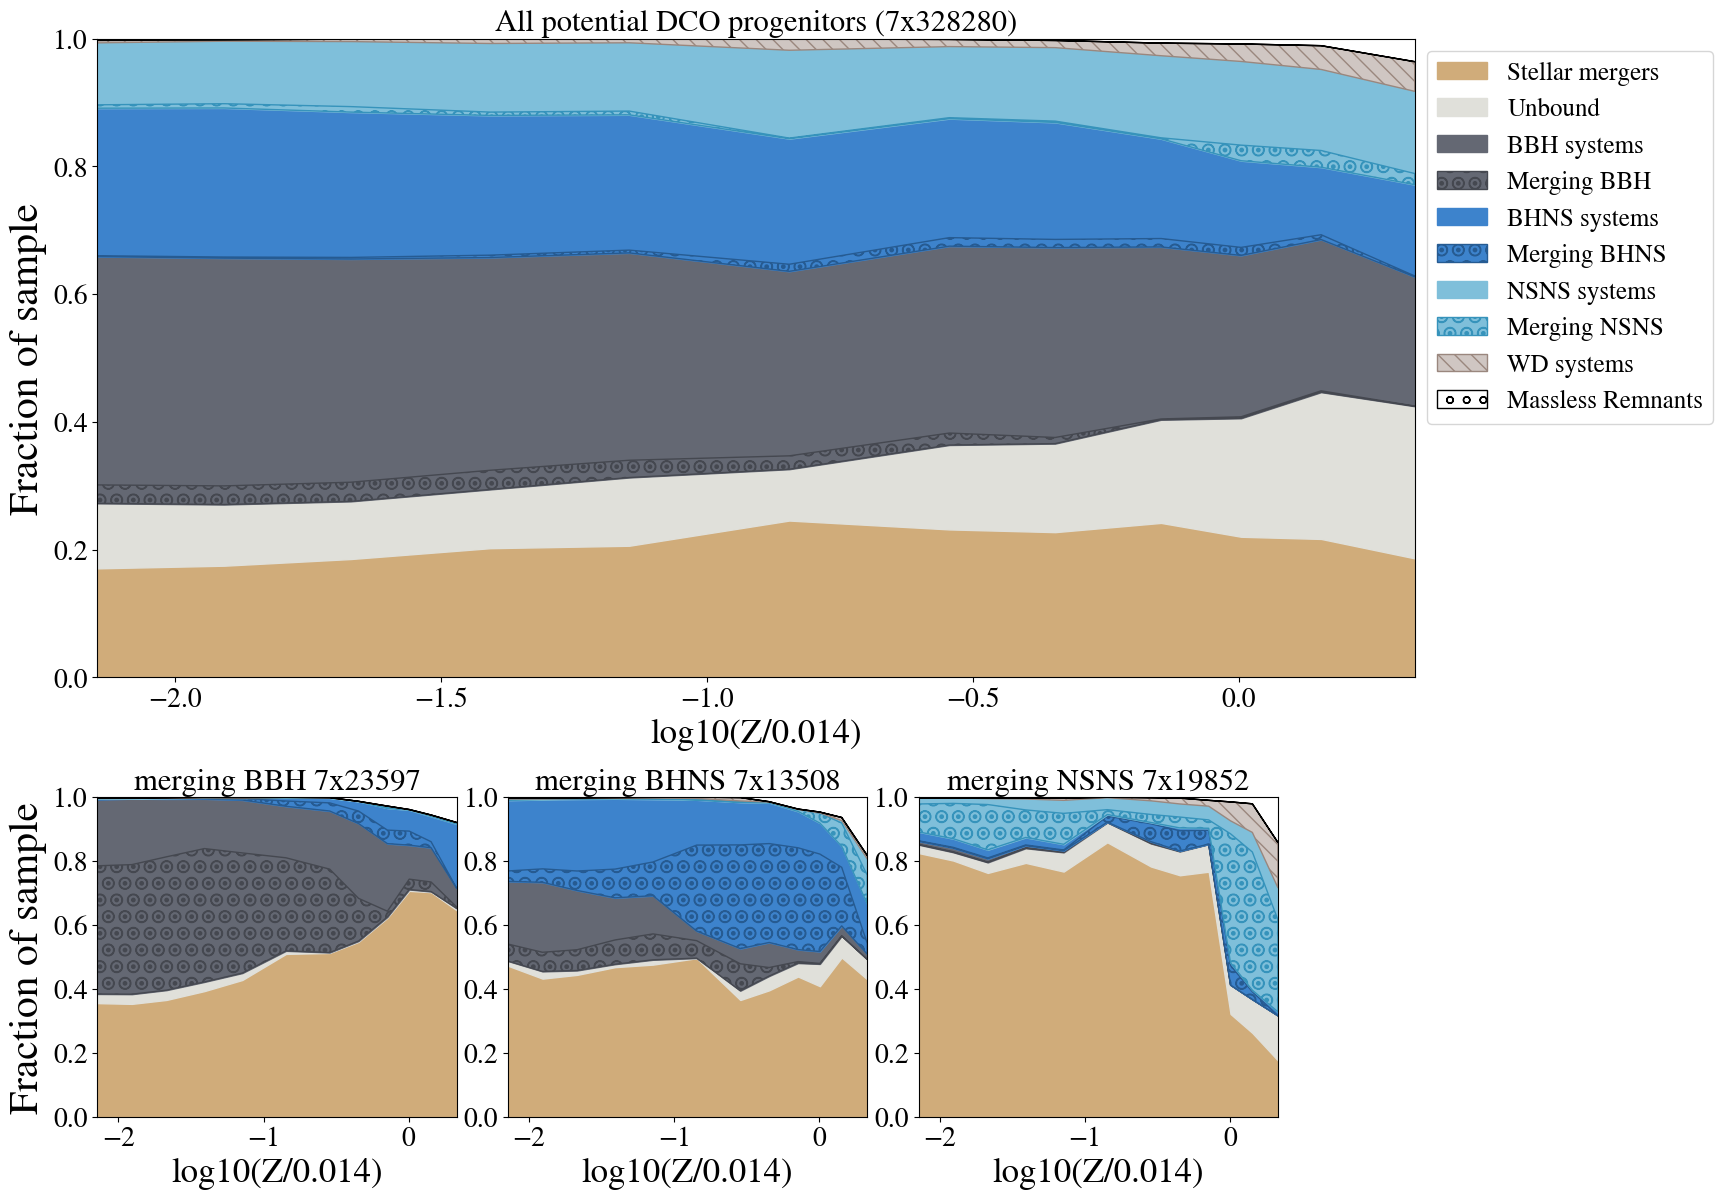

In [ ]:
metallicities = np.unique(potential_DCO_progenitors['Metallicity@ZAMS(1)'])
print('metallicities', metallicities)   
Z_Zsun = np.log10(np.array(metallicities)/0.014)

###########################################
# Create a figure
fig = plt.figure(figsize=(17, 14))

# Create a GridSpec with 2 rows and 5 columns
gs = GridSpec(2, 10, figure=fig, height_ratios=[2, 1])

# Create a big subplot on the top row that spans 3 out of 5 columns and is centered
ax1 = fig.add_subplot(gs[0, 0:])
# ax1 = fig.add_subplot(gs[0, 1:8])

# Create 3 equally sized subplots in the second row
axes = [ax1, fig.add_subplot(gs[1, 0:3]), fig.add_subplot(gs[1, 3:6]), fig.add_subplot(gs[1, 6:9])]

# Colors
color_dict = {'BBH': '#646873', 
              'BHNS': '#3d83cc',#'#4D7DAF', #'#e8485a', 
              'NSNS': '#7FBFDA', #'#8CBFDA',#'#778FD2',#91c74c',
              'WDWD': '#cfc6c2',
              'masslessRemnants': '#000000',
              'StellarMergers': '#d0ac7a',
              'UnboundSystems': '#e0e0da'}


DCO_flavors = ["All", "BBH", "BHNS", "NSNS"]
# Loop over the axes and DCO flavors
for ax, flavor in zip(axes, DCO_flavors):
    N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool = results[flavor] # get_endpoint_numbers(table = df)

    # Normalize or abs numbers?
    norm = N_tot_DCO_prog

    bottom = np.zeros(len(Z_Zsun))

    # stellar mergers
    ax.fill_between(Z_Zsun, bottom/norm, N_mergers/norm, color=color_dict['StellarMergers'], label='Stellar mergers', alpha = 1)
    bottom += N_mergers

    # Unbound systemd
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_unbound)/norm, color=color_dict['UnboundSystems'], label='Unbound', alpha = 1)
    bottom += N_unbound

    # BBH systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BBH)/norm, color=color_dict['BBH'], label='BBH systems', alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingBBH)/norm, color=color_dict['BBH'], 
                    edgecolor = darken_color(color_dict['BBH'], factor=0.7), hatch='O.', label='Merging BBH', alpha = 1)
    bottom += N_BBH

    # BHNS systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BHNS)/norm, color=color_dict['BHNS'], label='BHNS systems', alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingBHNS)/norm, color=color_dict['BHNS'], 
                    edgecolor = darken_color(color_dict['BHNS'], factor=0.7), hatch='O.', label='Merging BHNS', alpha = 1)
    bottom += N_BHNS

    # NSNS systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_NSNS)/norm, color=color_dict['NSNS'], label='NSNS systems', alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingNSNS)/norm, color=color_dict['NSNS'], 
                    edgecolor = darken_color(color_dict['NSNS'], factor=0.7), hatch='O.', label='Merging NSNS', alpha = 1)
    bottom += N_NSNS

    # WD systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_WD)/norm, color=color_dict['WDWD'],
                     edgecolor=darken_color(color_dict['WDWD'], factor=0.7), hatch = '\\\\', label='WD systems', alpha = 1)   
    bottom += N_WD

    # Massless remnants
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_massless_rem)/norm, color='none',edgecolor=color_dict['masslessRemnants'], hatch = 'o', label='Massless Remnants', alpha = 1)
    bottom += N_massless_rem

    # Other
    # print(N_other)
    # ax.fill_between(Z_Zsun, bottom, (bottom + N_other)/norm, color='r', label='Other', alpha = 1)

    if flavor == 'All':
        ax.set_title(f'All potential DCO progenitors (7x{N_tot_DCO_prog[0.0001]})', fontsize = 22)
    else:
        ax.set_title(f'merging {flavor} 7x{N_tot_DCO_prog[0.0001]}', fontsize = 22)
        
    ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
    ax.set_ylim(0,1)

#########################
# plotvalues
fig.subplots_adjust(hspace=0.25, wspace=0.6)

axes[0].set_xlabel('log10(Z/0.014)', fontsize = 25)
axes[1].set_xlabel('log10(Z/0.014)', fontsize = 25)
axes[2].set_xlabel('log10(Z/0.014)', fontsize = 25)
axes[3].set_xlabel('log10(Z/0.014)', fontsize = 25)
axes[0].set_ylabel("Fraction of sample", fontsize =30)
axes[1].set_ylabel("Fraction of sample", fontsize =30)

axes[0].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize = 18, ncols = 1)

plt.savefig(home_dir + f'/Winds2/plots_v46/End_Of_Evol_per_Z_{sim_name}.pdf', bbox_inches='tight')
plt.show()


metallicities [0.0001     0.00017321 0.0003     0.00054772 0.001      0.002
 0.004      0.00632456 0.01       0.01414214 0.02       0.03      ]


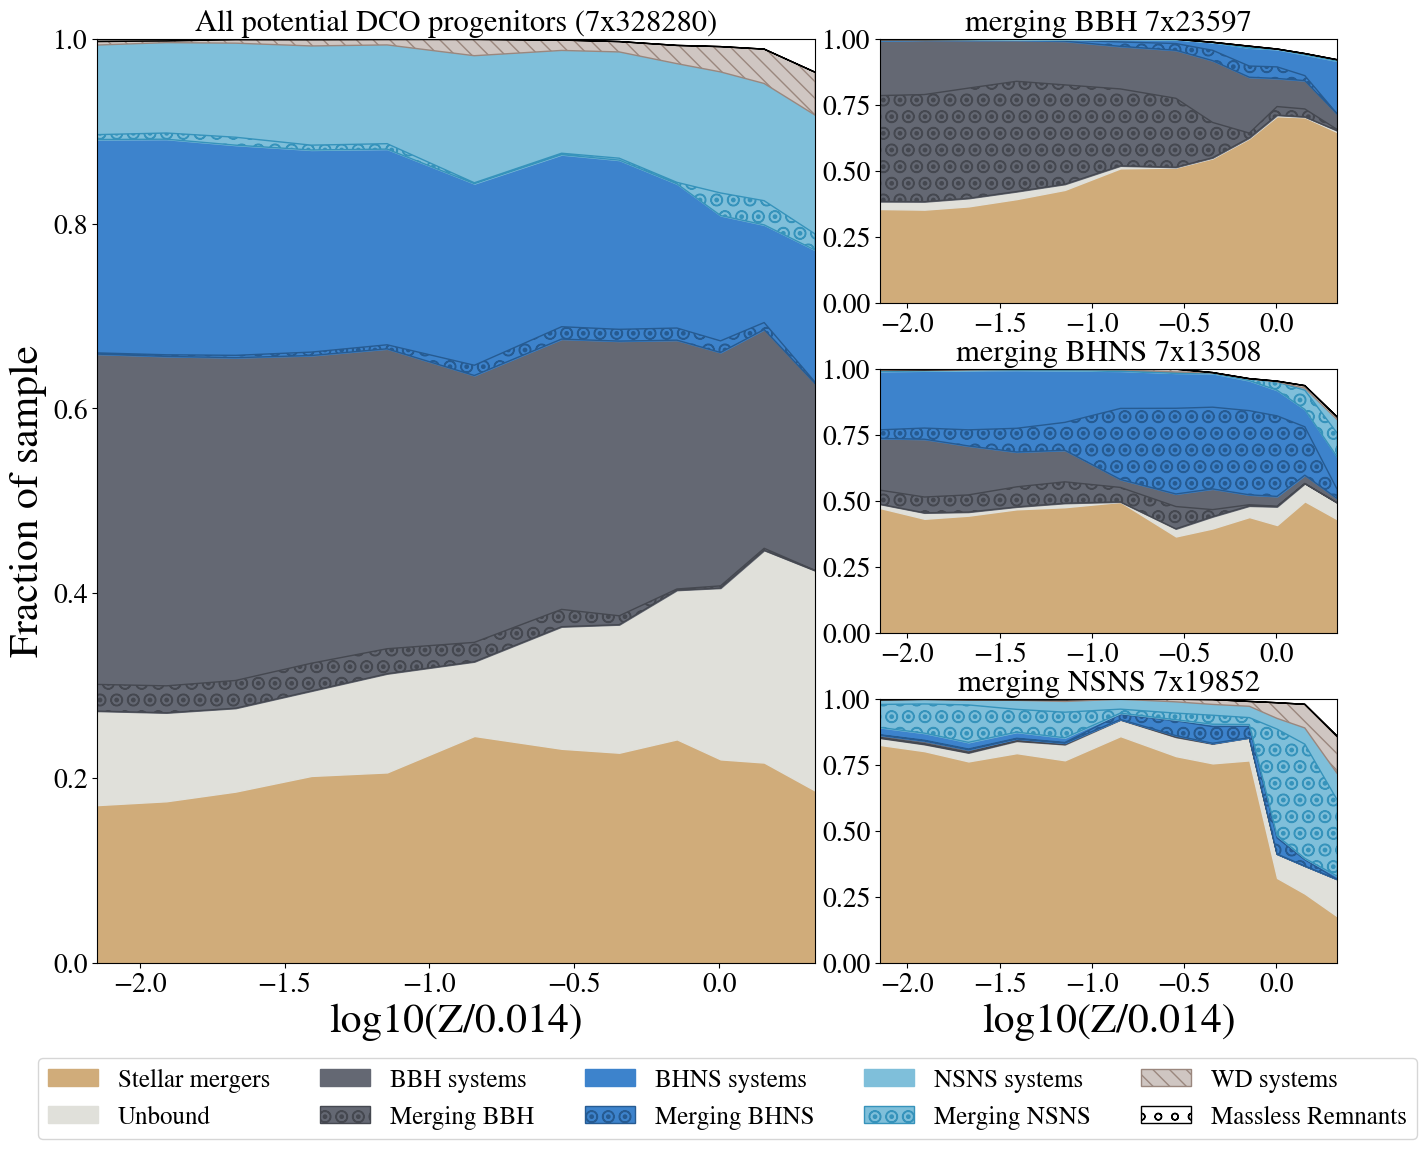

In [ ]:
metallicities = np.unique(potential_DCO_progenitors['Metallicity@ZAMS(1)'])
print('metallicities', metallicities)   
Z_Zsun = np.log10(np.array(metallicities)/0.014)

###########################################
# Create a figure
fig = plt.figure(figsize=(16, 12))

# Create a GridSpec with 3 rows and 2 columns
gs = GridSpec(3, 10, figure=fig)#, width_ratios=[60, 40])
ax1 = fig.add_subplot(gs[:, 0:6])    # Create a big subplot on the left (for all DCOs)
axes = [ax1, fig.add_subplot(gs[0, 6:10]), fig.add_subplot(gs[1, 6:10]), fig.add_subplot(gs[2, 6:10])]  #  3 small subplots on the right


# Colors
color_dict = {'BBH': '#646873', 
              'BHNS': '#3d83cc',#'#4D7DAF', #'#e8485a', 
              'NSNS': '#7FBFDA', #'#8CBFDA',#'#778FD2',#91c74c',
              'WDWD': '#cfc6c2',
              'masslessRemnants': '#000000',
              'StellarMergers': '#d0ac7a',
              'UnboundSystems': '#e0e0da'}


DCO_flavors = ["All", "BBH", "BHNS", "NSNS"]
# Loop over the axes and DCO flavors
for ax, flavor in zip(axes, DCO_flavors):
    N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool = results[flavor] # get_endpoint_numbers(table = df)

    # Normalize or abs numbers?
    norm = N_tot_DCO_prog

    bottom = np.zeros(len(Z_Zsun))

    # stellar mergers
    ax.fill_between(Z_Zsun, bottom/norm, N_mergers/norm, color=color_dict['StellarMergers'], label='Stellar mergers', alpha = 1)
    bottom += N_mergers

    # Unbound systemd
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_unbound)/norm, color=color_dict['UnboundSystems'], label='Unbound', alpha = 1)
    bottom += N_unbound

    # BBH systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BBH)/norm, color=color_dict['BBH'], label='BBH systems', alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingBBH)/norm, color=color_dict['BBH'], 
                    edgecolor = darken_color(color_dict['BBH'], factor=0.7), hatch='O.', label='Merging BBH', alpha = 1)
    bottom += N_BBH

    # BHNS systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BHNS)/norm, color=color_dict['BHNS'], label='BHNS systems', alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingBHNS)/norm, color=color_dict['BHNS'], 
                    edgecolor = darken_color(color_dict['BHNS'], factor=0.7), hatch='O.', label='Merging BHNS', alpha = 1)
    bottom += N_BHNS

    # NSNS systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_NSNS)/norm, color=color_dict['NSNS'], label='NSNS systems', alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingNSNS)/norm, color=color_dict['NSNS'], 
                    edgecolor = darken_color(color_dict['NSNS'], factor=0.7), hatch='O.', label='Merging NSNS', alpha = 1)
    bottom += N_NSNS

    # WD systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_WD)/norm, color=color_dict['WDWD'],
                     edgecolor=darken_color(color_dict['WDWD'], factor=0.7), hatch = '\\\\', label='WD systems', alpha = 1)   
    bottom += N_WD

    # Massless remnants
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_massless_rem)/norm, color='none',edgecolor=color_dict['masslessRemnants'], hatch = 'o', label='Massless Remnants', alpha = 1)
    bottom += N_massless_rem

    # Other
    # print(N_other)
    # ax.fill_between(Z_Zsun, bottom, (bottom + N_other)/norm, color='r', label='Other', alpha = 1)

    if flavor == 'All':
        ax.set_title(f'All potential DCO progenitors (7x{N_tot_DCO_prog[0.0001]})', fontsize = 22)
    else:
        ax.set_title(f'merging {flavor} 7x{N_tot_DCO_prog[0.0001]}', fontsize = 22)
        
    ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
    ax.set_ylim(0,1)

#########################
# plotvalues
fig.subplots_adjust(hspace=0.25, wspace=1)

axes[0].set_xlabel('log10(Z/0.014)', fontsize = 30)
axes[3].set_xlabel('log10(Z/0.014)', fontsize = 30)
axes[0].set_ylabel("Fraction of sample", fontsize =30)

axes[0].legend(bbox_to_anchor=(-0.1, -0.09), loc='upper left', fontsize = 18, ncols = 5)
# axes[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize = 20)

plt.savefig(home_dir + f'/Winds2/plots_v46/End_Of_Evol_per_Z_{sim_name}.pdf', bbox_inches='tight')
plt.show()


### investigating the "other systems"

### Add supernova information to your table

In [ ]:
####################################
# check if your table exists
prog_table_name = 'potential_DCO_progenitors_info.h5'

if os.path.isfile(datar_root+ f'{sim_name}/'+prog_table_name):
    potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/' + prog_table_name, key='All_DCO')
    print('Table exists, reading in... ',  potential_DCO_progenitors.info())

else:
    with h5.File(datar_root+f'/{sim_name}/COMPAS_Output_combinedZ.h5', 'r') as All_data:        
        # Read SN info as pandas dataframes
        SNe = pd.DataFrame()
        SN_keys_of_interest = ['SEED', 'Metallicity@ZAMS(1)', 'SN_Type(SN)', 'Supernova_State']
        for key in SN_keys_of_interest:
            SNe[key] = All_data['BSE_Supernovae'][key][()]
        #Add unique seed key
        SNe['unique_Z_SEED'] = [f"{seed}_{Z:.5f}" for seed, Z in zip(SNe['SEED'], SNe['Metallicity@ZAMS(1)'])]


    # Star 1 is going SN
    star1_SN = SNe[SNe['Supernova_State'] == 1]

    # Star 2 is going SN
    star2_SN = SNe[SNe['Supernova_State'] == 2]

    # Add the SN info to the potential DCO progenitors
    potential_DCO_progenitors['SN_Type(1)'] = potential_DCO_progenitors['unique_Z_SEED'].map(star1_SN.set_index('unique_Z_SEED')['SN_Type(SN)']).fillna(-1)

    potential_DCO_progenitors['SN_Type(2)'] = potential_DCO_progenitors['unique_Z_SEED'].map(star2_SN.set_index('unique_Z_SEED')['SN_Type(SN)']).fillna(-1)

    # display(potential_DCO_progenitors[['SEED', 'Metallicity@ZAMS(1)','unique_Z_SEED', 'Stellar_Type(1)', 'Stellar_Type(2)', 'SN_Type(1)', 'SN_Type(2)']])

    #################################################################################
    # Save the dataframe
    print('Done!, Saving the potential DCO progenitors with MT info')
    potential_DCO_progenitors.to_hdf(datar_root+ f'{sim_name}/'+prog_table_name, key='All_DCO', mode='w')


# Supernova_State 1
# No supernova = 0 
# Star 1 is the supernova 	 = 1 
# Star 2 is the supernova 	 = 2 
# Both stars are supernovae 	 = 3

# NONE 	 = 0 
# CCSN 	 = 1 
# ECSN 	 = 2 
# PISN 	 = 4 
# PPISN 	 = 8 
# USSN 	 = 16 
# AIC 	 = 32 
# SNIA 	 = 64 
# HeSD 	 = 128

Done!, Saving the potential DCO progenitors with MT info


/tmp/ipykernel_3000395/2535480601.py:36: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'unique_Z_SEED'], dtype='object')]

  potential_DCO_progenitors.to_hdf(datar_root+ f'{sim_name}/'+prog_table_name, key='All_DCO', mode='w')


In [ ]:

other_table = potential_DCO_progenitors[]

display(other_table[['SEED', 'Metallicity@ZAMS(1)', 'Stellar_Type(1)', 'SN_Type(1)', 'Stellar_Type(2)','SN_Type(2)', 'Merger', 'Merger_At_Birth', 'Unbound', 'Optimistic_CE']])


SyntaxError: invalid syntax (2370430683.py, line 1)

In [ ]:
N_other = N_tot_DCO_prog - ( N_unbound + N_mergers + N_BBH + N_BHNS + N_NSNS + N_WD + N_massless_rem)
print('N_other', N_other)

N_other Metallicity@ZAMS(1)
0.0001      37
0.0003      28
0.0010      63
0.0040     137
0.0100     646
0.0200     805
0.0300    1301
dtype: int64


In [ ]:
####################################
# check if your table exists
save_name_table = 'potential_DCO_progenitors_MTinfo1.h5'
if os.path.isfile(datar_root+ f'{sim_name}/{save_name_table}'):
    potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/{save_name_table}', key='All_DCO')
    print('Table exists, reading in... ',  potential_DCO_progenitors.info())

else:
    ####################################
    print('Reading the RLOF data')
    # Load the RLOF table in chunks (so prevent memory issues)
    chunksize = 10 ** 6  # adjust this value depending on your available memory
    chunks = []
    with h5.File(datar_root+ f'/{sim_name}/COMPAS_Output_combinedZ.h5', 'r') as All_data:
        data = All_data['BSE_RLOF']
        for i in range(0, len(data['SEED'][()]), chunksize):
            chunk = pd.DataFrame({key: data[key][i:i+chunksize] for key in data.keys()})
            chunk['M1_M2<MT'] = chunk['Mass(1)<MT']/chunk['Mass(2)<MT'].astype(float)
            chunk['unique_Z_SEED'] = [f"{seed}_{Z:.5f}" for seed, Z in zip(chunk['SEED'], chunk['Metallicity@ZAMS(1)'])]
            chunks.append(chunk)
    RLOF = pd.concat(chunks)
    del chunks # Delete the chunks list to free up memory

    # Convert columns to more memory-efficient data types
    for col in RLOF.columns:
        if RLOF[col].dtype == np.float64:
            RLOF[col] = RLOF[col].astype(np.float32)


    ########################################################################################
    ###   add info from the first mass tranfer that occurs to the potential DCO table    ##
    print('Adding first RLOF info to potential DCO progenitors')
    first_RLOF = RLOF[RLOF['MT_Event_Counter'] == 1] # This is the first mass transfer occuring

    # And these are RLOF events for systems in the potential DCO table
    First_RLOF_to_potential_DCO = first_RLOF['unique_Z_SEED'].isin(potential_DCO_progenitors['unique_Z_SEED'])
    first_RLOF_inDCO = first_RLOF[First_RLOF_to_potential_DCO] # this is now unique in unique_Z_SEED

    # first_rlof_inDCO_seed, counts = np.unique(first_RLOF_inDCO['unique_Z_SEED'], return_counts=True )
    # print('first_rlof_inDCO_seed, counts ', first_rlof_inDCO_seed, counts  )
    # print(np.unique(counts))

    # Add RLOF information to potential_DCO_progenitors
    keys = ['SemiMajorAxis<MT', 'SemiMajorAxis>MT', 'Radius(1)<MT', 'Radius(2)<MT', 'Radius(1)>MT', 'Radius(2)>MT', 
            'Mass(1)<MT', 'Mass(2)<MT', 'Mass(1)>MT', 'Mass(2)>MT',
            'M1_M2<MT', 'CEE>MT', 'RLOF(1)>MT', 'RLOF(2)>MT', 'Stellar_Type(1)<MT', 'Stellar_Type(2)<MT', 'MT_Event_Counter', 'Merger']

    for key in keys:
        potential_DCO_progenitors['firstMT_'+key] = potential_DCO_progenitors['unique_Z_SEED'].map(first_RLOF_inDCO.set_index('unique_Z_SEED')[key]).fillna(-1)


    #################################################################################
    ###    add info from the first mass tranfer that occurs to the potential DCO table      ###
    # Filter RLOF events where star 2 is RLOF and could potentially become a DCO
    print('Adding the first MT from star 2 to DCO progenitors, this might take a while.. ')
    firt_RLOF_star2_potential_DCO = np.logical_and(RLOF['RLOF(2)>MT'] == 1, RLOF['unique_Z_SEED'].isin(potential_DCO_progenitors['unique_Z_SEED']) ) 
    RLOF_star2MT_and_inDCO = RLOF[firt_RLOF_star2_potential_DCO]

    # For every unique_Z_SEED in RLOF_star2MT_and_inDCO, keep only the row where MT_Event_Counter is minimum
    # Essentially this means we are picking the first MT where star 2 is RLOF and could potentially become a DCO
    df_RLOF_star2MT_and_inDCO = RLOF_star2MT_and_inDCO.groupby('unique_Z_SEED').idxmin().reset_index() #reset_index() is needed to keep the unique_Z_SEED as a column

    # Add this information to the potential_DCO_progenitors
    keys = ['SemiMajorAxis<MT', 'SemiMajorAxis>MT', 'Radius(1)<MT', 'Radius(2)<MT', 'Radius(1)>MT', 'Radius(2)>MT', 'Mass(1)<MT', 'Mass(2)<MT', 'Mass(1)>MT', 'Mass(2)>MT',
            'M1_M2<MT', 'CEE>MT', 'RLOF(1)>MT', 'RLOF(2)>MT', 'Stellar_Type(1)<MT', 'Stellar_Type(2)<MT', 'MT_Event_Counter', 'Merger']

    for key in keys:
        # Create the columns
        potential_DCO_progenitors['star2_firstMT_'+key] = potential_DCO_progenitors['unique_Z_SEED'].map(df_RLOF_star2MT_and_inDCO.set_index('unique_Z_SEED')[key]).fillna(-1)

    #################################################################################
    # Save the dataframe
    print('Done!, Saving the potential DCO progenitors with MT info')
    potential_DCO_progenitors.to_hdf(datar_root+ f'{sim_name}/{save_name_table}', key='All_DCO', mode='w')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5683984 entries, 0 to 16999997
Data columns (total 61 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   SEED                              uint64 
 1   Metallicity@ZAMS(1)               float64
 2   Stellar_Type(1)                   int32  
 3   Stellar_Type(2)                   int32  
 4   CE_Event_Counter                  uint32 
 5   Mass@ZAMS(1)                      float64
 6   Mass@ZAMS(2)                      float64
 7   SemiMajorAxis@ZAMS                float64
 8   Merger                            uint8  
 9   Merger_At_Birth                   uint8  
 10  Unbound                           uint8  
 11  Immediate_RLOF>CE                 uint8  
 12  Optimistic_CE                     uint8  
 13  Applied_Kick_Magnitude(1)         float64
 14  Applied_Kick_Magnitude(2)         float64
 15  CH_on_MS(1)                       uint8  
 16  Merges_Hubble_Time                f

### Add supernova information to your table

In [ ]:
####################################
# check if your table exists
prog_table_name = 'potential_DCO_progenitors_info.h5'

if os.path.isfile(datar_root+ f'{sim_name}/'+prog_table_name):
    potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/' + prog_table_name, key='All_DCO')
    print('Table exists, reading in... ',  potential_DCO_progenitors.info())

else:
    with h5.File(datar_root+f'/{sim_name}/COMPAS_Output_combinedZ.h5', 'r') as All_data:        
        # Read SN info as pandas dataframes
        SNe = pd.DataFrame()
        SN_keys_of_interest = ['SEED', 'Metallicity@ZAMS(1)', 'SN_Type(SN)', 'Supernova_State']
        for key in SN_keys_of_interest:
            SNe[key] = All_data['BSE_Supernovae'][key][()]
        #Add unique seed key
        SNe['unique_Z_SEED'] = [f"{seed}_{Z:.5f}" for seed, Z in zip(SNe['SEED'], SNe['Metallicity@ZAMS(1)'])]


    # Star 1 is going SN
    star1_SN = SNe[SNe['Supernova_State'] == 1]

    # Star 2 is going SN
    star2_SN = SNe[SNe['Supernova_State'] == 2]

    # Add the SN info to the potential DCO progenitors
    potential_DCO_progenitors['SN_Type(1)'] = potential_DCO_progenitors['unique_Z_SEED'].map(star1_SN.set_index('unique_Z_SEED')['SN_Type(SN)']).fillna(-1)

    potential_DCO_progenitors['SN_Type(2)'] = potential_DCO_progenitors['unique_Z_SEED'].map(star2_SN.set_index('unique_Z_SEED')['SN_Type(SN)']).fillna(-1)

    # display(potential_DCO_progenitors[['SEED', 'Metallicity@ZAMS(1)','unique_Z_SEED', 'Stellar_Type(1)', 'Stellar_Type(2)', 'SN_Type(1)', 'SN_Type(2)']])

    #################################################################################
    # Save the dataframe
    print('Done!, Saving the potential DCO progenitors with MT info')
    potential_DCO_progenitors.to_hdf(datar_root+ f'{sim_name}/'+prog_table_name, key='All_DCO', mode='w')


# Supernova_State 1
# No supernova = 0 
# Star 1 is the supernova 	 = 1 
# Star 2 is the supernova 	 = 2 
# Both stars are supernovae 	 = 3

# NONE 	 = 0 
# CCSN 	 = 1 
# ECSN 	 = 2 
# PISN 	 = 4 
# PPISN 	 = 8 
# USSN 	 = 16 
# AIC 	 = 32 
# SNIA 	 = 64 
# HeSD 	 = 128

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5683984 entries, 0 to 16999997
Data columns (total 63 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   SEED                              uint64 
 1   Metallicity@ZAMS(1)               float64
 2   Stellar_Type(1)                   int32  
 3   Stellar_Type(2)                   int32  
 4   CE_Event_Counter                  uint32 
 5   Mass@ZAMS(1)                      float64
 6   Mass@ZAMS(2)                      float64
 7   SemiMajorAxis@ZAMS                float64
 8   Merger                            uint8  
 9   Merger_At_Birth                   uint8  
 10  Unbound                           uint8  
 11  Immediate_RLOF>CE                 uint8  
 12  Optimistic_CE                     uint8  
 13  Applied_Kick_Magnitude(1)         float64
 14  Applied_Kick_Magnitude(2)         float64
 15  CH_on_MS(1)                       uint8  
 16  Merges_Hubble_Time                f